In [1]:
from pathlib import Path

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from mycolorpy import colorlist as mcp

from Atools.base import Mols

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('font', size=10)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=15)
plt.rc('legend', fontsize=10)
plt.rcParams["figure.figsize"] = (10, 7)

In [2]:
D = pd.read_csv(r'Datas\MD.csv', index_col=0)
V = pd.read_csv(r'Datas\Viscosity.csv', index_col=0)[
    ['x', 'Temperature', 'rho', 'w_mass', 'w_vol', 'Viscosity', 'compound']
]
V['x'] = V['x'].astype(int)

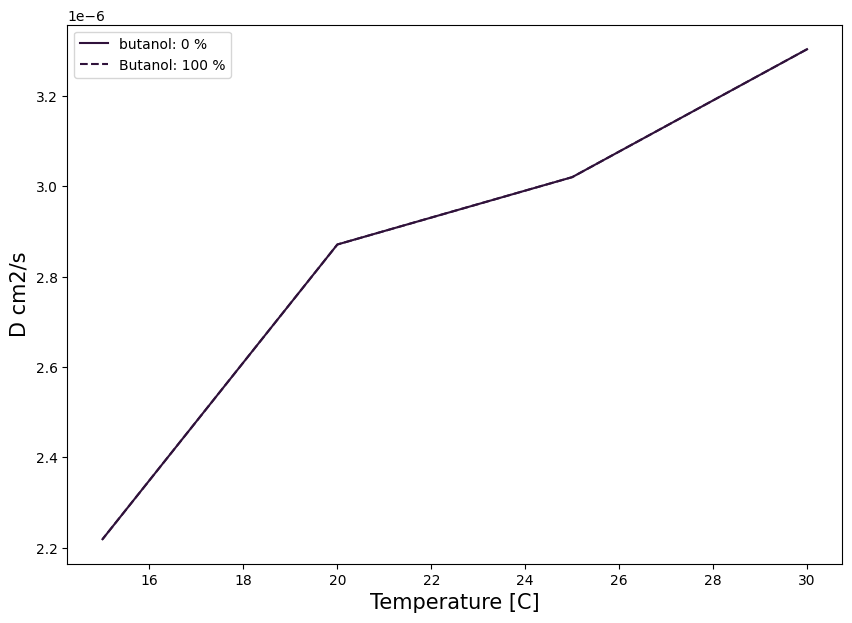

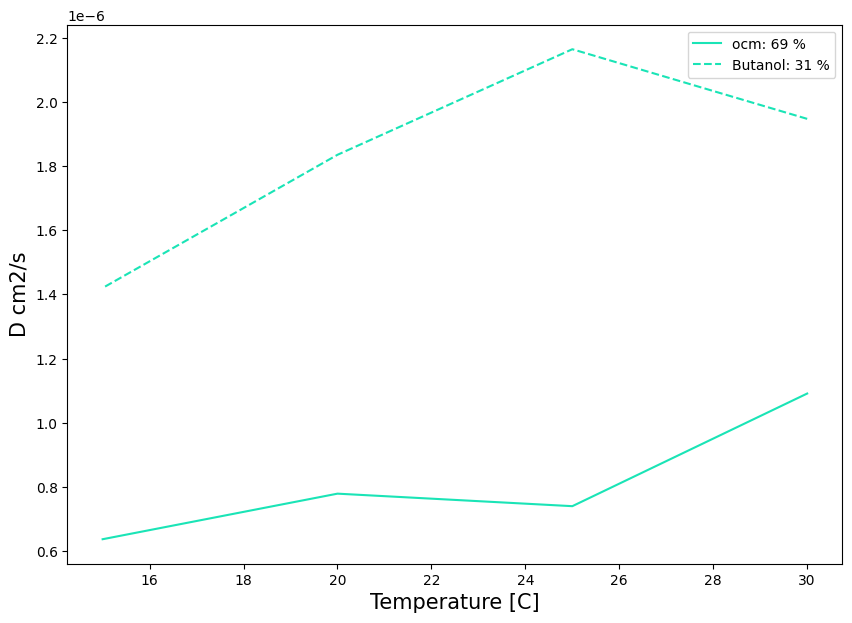

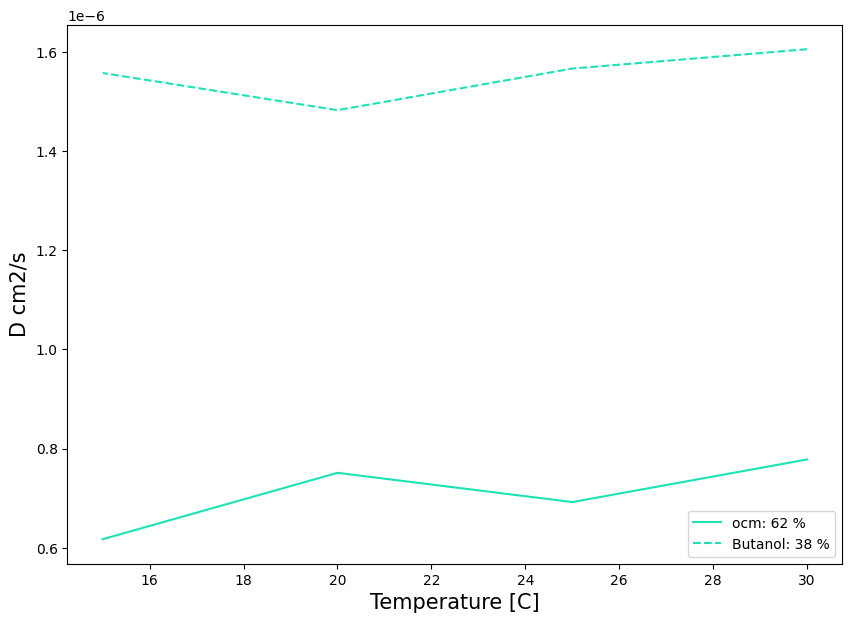

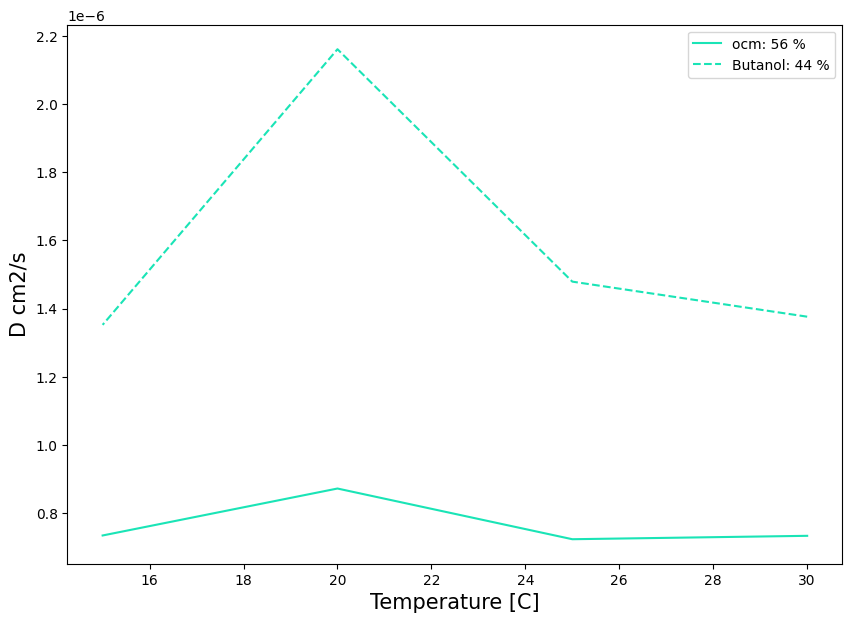

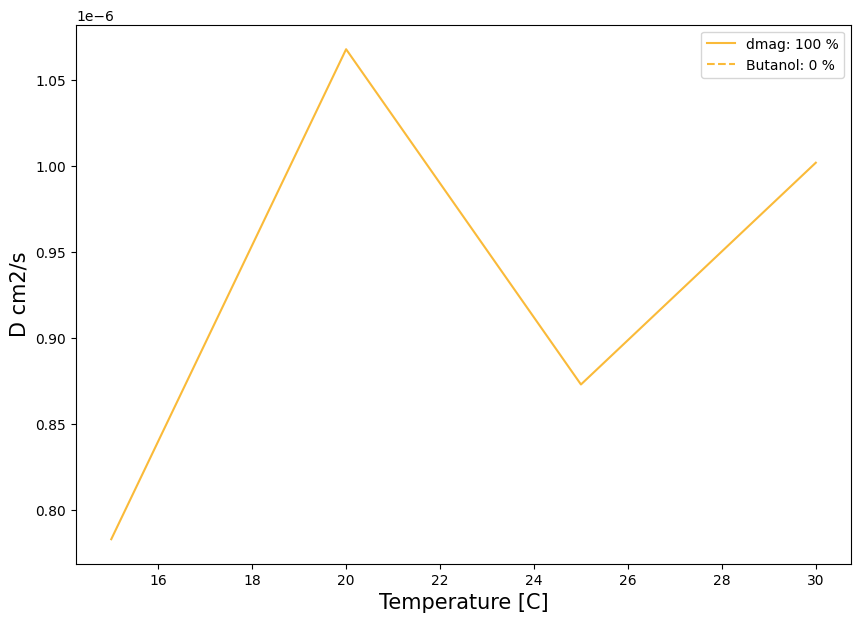

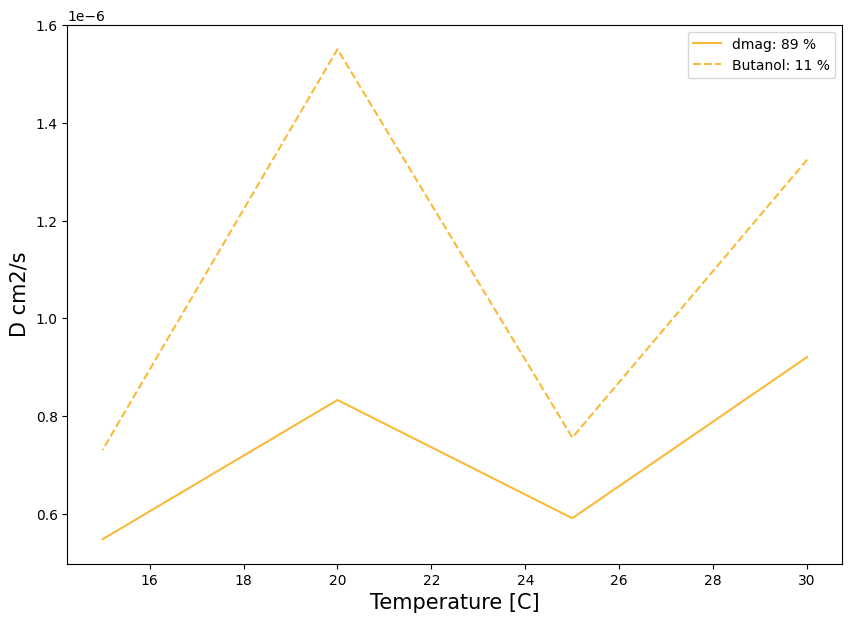

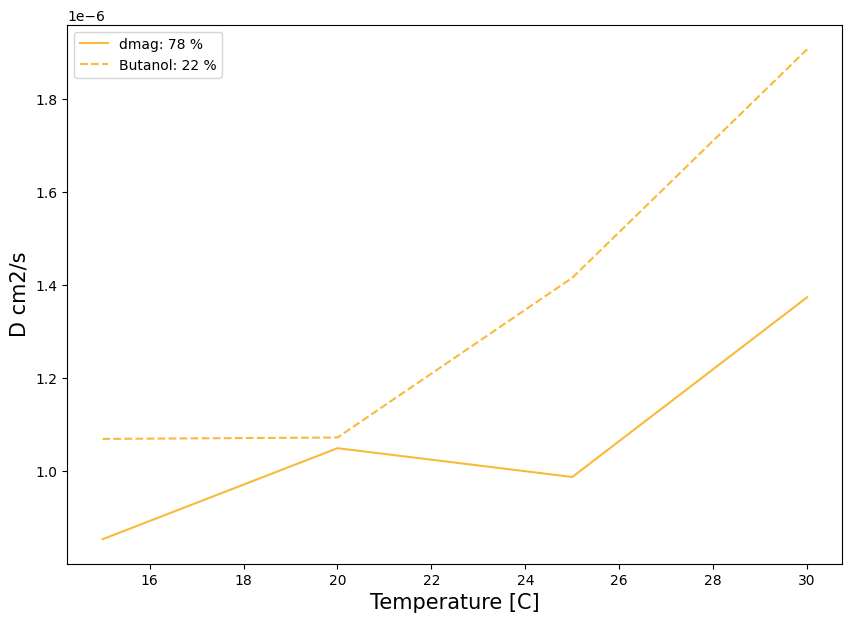

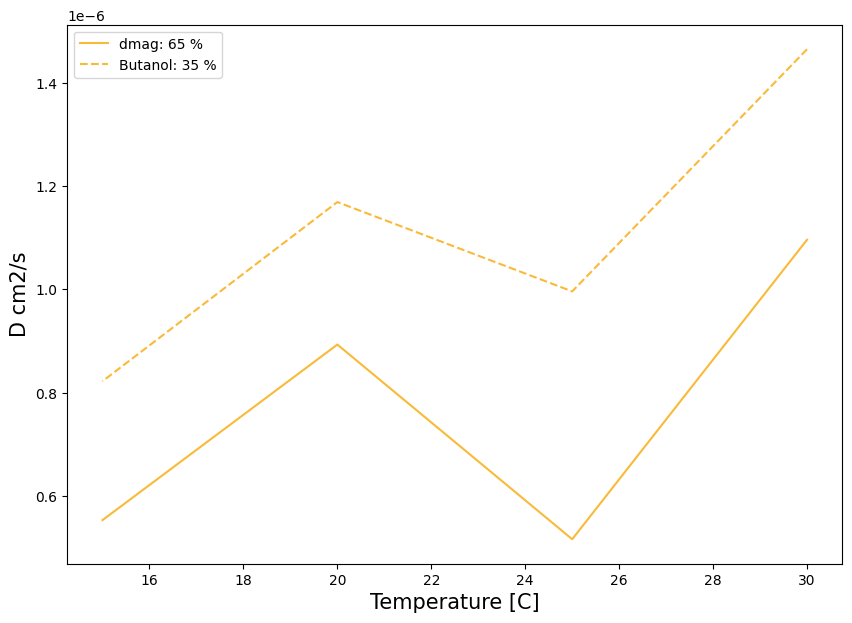

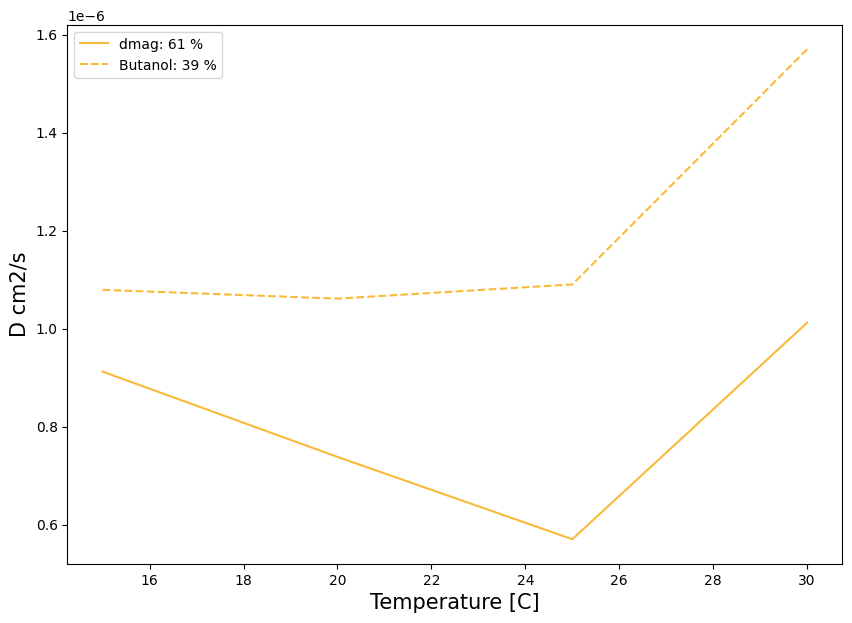

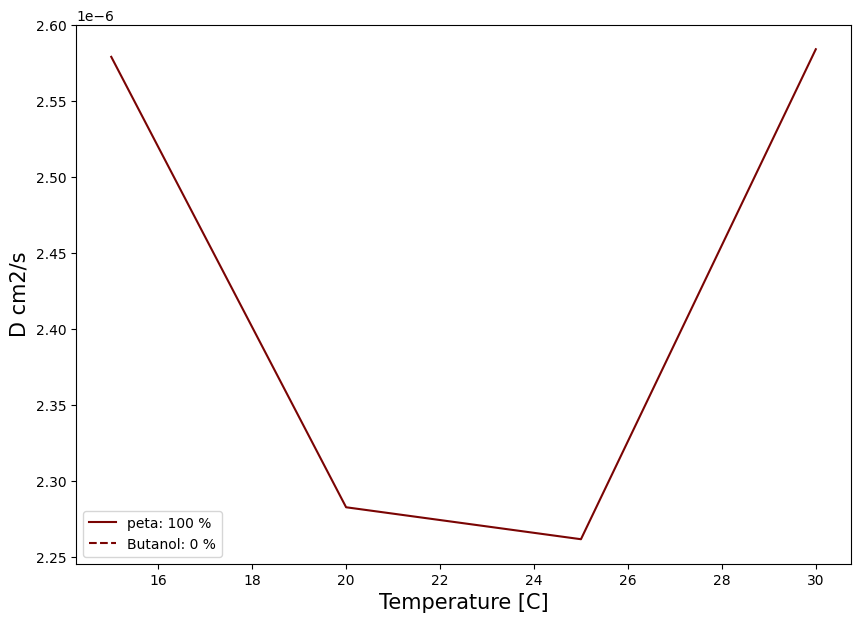

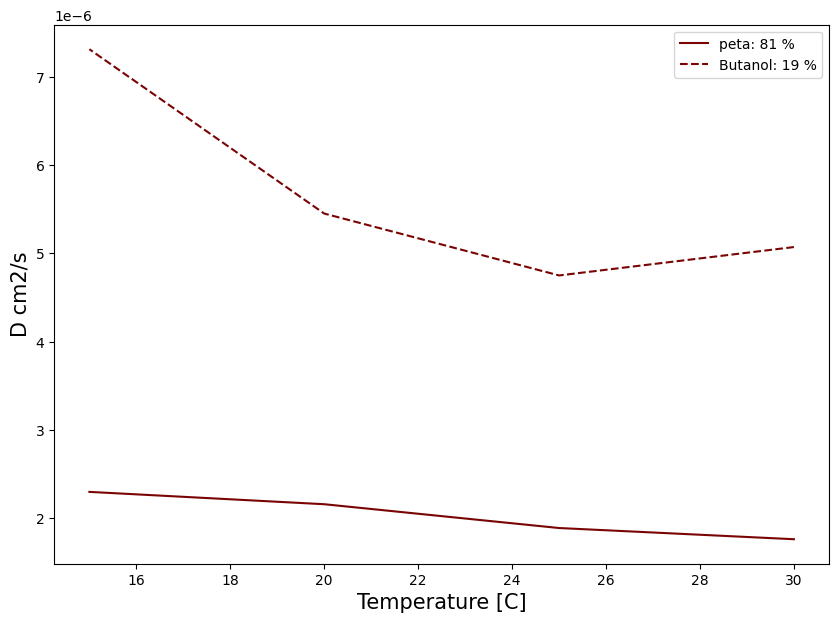

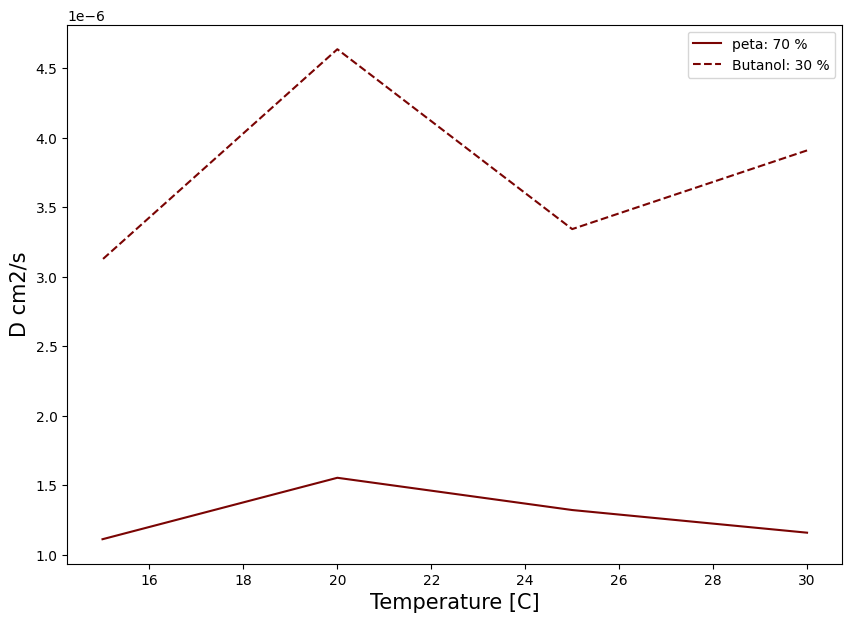

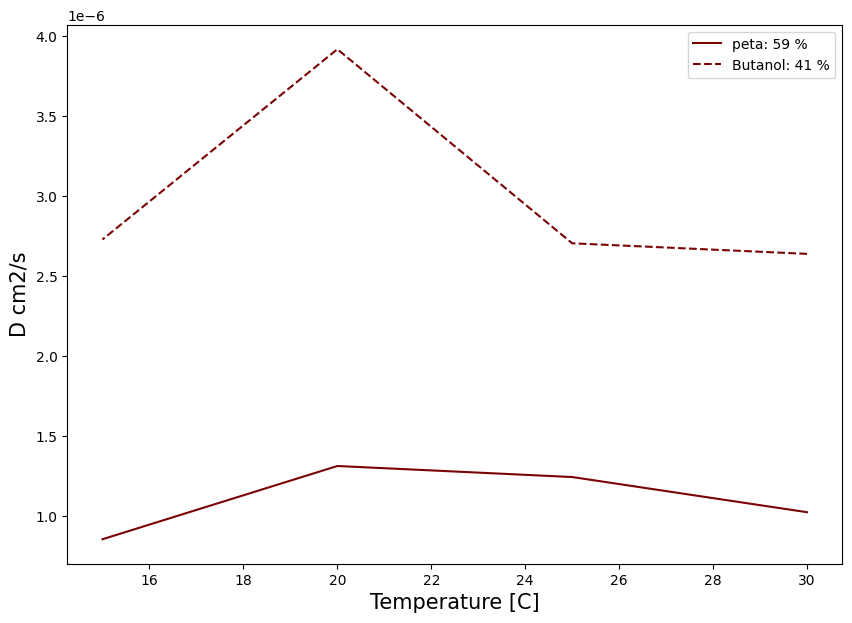

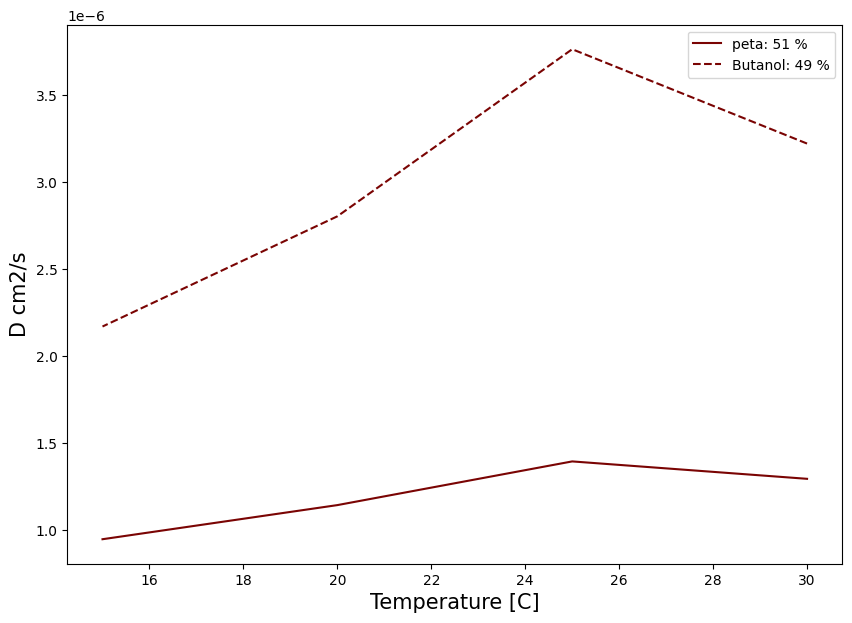

In [3]:
# D
colors_list = mcp.gen_color(
    cmap="turbo",
    n=len(D['compound'].unique()),
)
for i, compound in enumerate(Mols):
    df_sub = D[D['compound'] == compound.name]
    if len(df_sub) == 0:
        continue
    for [x], df in df_sub.groupby(by=['x']):
        fig, ax = plt.subplots(num="DT")
        data_x = df.sort_values(by=['Temperature'], ascending=False)
        ax.plot(
            data_x['Temperature'],
            data_x['D_comp'],
            label=f"{compound.name}: {100-x} %",
            c=colors_list[i],
        )
        ax.plot(
            data_x['Temperature'],
            data_x['D_but'],
            linestyle='dashed',
            label=f"Butanol: {x} %",
            c=colors_list[i],
        )

        ax.set_xlabel("Temperature [C]")
        ax.set_ylabel("D cm2/s")
        ax.legend()
        plt.show()

In [4]:
def calculate_h_comp(r: pd.Series):
    T = r['Temperature'] + 273.15
    v = r['Viscosity']
    D_comp = r['D_comp']
    return T / (v * D_comp)


def calculate_h_but(r: pd.Series):
    T = r['Temperature'] + 273.15
    v = r['Viscosity']
    D_but = r['D_but']
    return T / (v * D_but) if D_but else np.nan


M = pd.merge(D, V, on=['x', 'Temperature', 'compound'], how='inner')
M['H_comp'] = M.apply(calculate_h_comp, axis=1)
M['H_but'] = M.apply(calculate_h_but, axis=1)

d_dict = {}
for name, group in M.groupby(by='compound'):
    H_comp = np.array(group['H_comp'])
    if name == 'butanol':
        H_but = np.array(M['D_but'])
        H_comp = np.array([*H_comp, *H_but])[:]

    H0 = np.median(H_comp)
    d_dict[name] = H0

In [5]:
def calculate_D(r):
    v = r['Viscosity']
    T = r['Temperature'] + 273
    comp = r['compound']
    h = d_dict[comp]
    return T / v / h


def calculate_D_but(r):
    v = r['Viscosity']
    T = r['Temperature'] + 273
    h = d_dict['butanol']
    return T / v / h


M['D_comp'] = M['D_comp']
M['D_comp1'] = M.apply(calculate_D, axis=1)
M['D_but'] = M['D_but']
M['D_but1'] = M.apply(calculate_D_but, axis=1)
M.to_csv(r'Datas\MD_merged.csv')
M.head(2)

,compound,x,Temperature,D_comp,D_but,rho,w_mass,w_vol,Viscosity,H_comp,H_but,D_comp1,D_but1
0,butanol,100,15,0.000002,0.000002,0.7,100.0,100.0,3.600238,3.606867e+07,3.606867e+07,NaN,NaN
1,butanol,100,20,0.000003,0.000003,0.7,100.0,100.0,3.241333,3.150163e+07,3.150163e+07,NaN,NaN


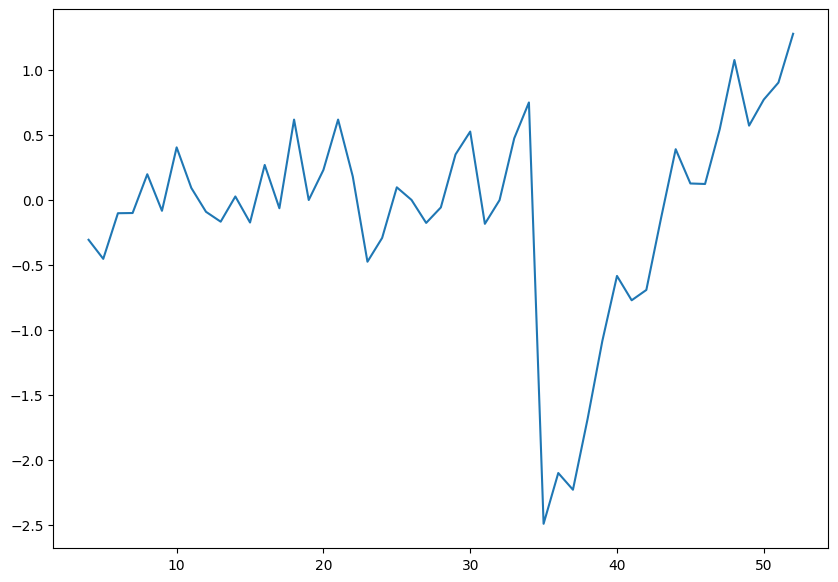

In [46]:
plt.plot(
    np.log(M['D_comp1']/M['D_comp'])
)